prompt:  load the parquet fies we created in the other two notebooks and perform
a regression to analyze the relationship between median income of a tract
(independent variable ) and the average download speeds (dependent variable ) in
that tract. You will need to do a spatial join on the two dataset, to locate
each point from the uss_mobile_2022q1 dataset to a census tract, then aggregate
by tract, computing the average or median download speed or upload speed. You
should create an analysis function to parameterize which statistic of central
tendencay we use, and which dependent variable we use. Use statsmodel for the OLS. 

## Updates

[ When you have completed an update, put `[DONE]` in front of it, after the bullet. ]

* [DONE] You do not need to create Points from tile_x and til_y in the uss_mobile dataset, there is already a geometry field. You might have to use shapely.loads to convert that from a string to a geometry, but check first.

* [DONE] Aggregating the joined dataset:  average these fields: ['avg_d_kbps',
  'avg_u_kbps', 'avg_lat_ms', 'avg_lat_down_ms', 'avg_lat_up_ms']. sum these
  fields: ['tests', 'devices']. group by: 'GEOID'. There should be only one
  'median_income', and it should be passed through. 



In [47]:
 # Enable autoreload and import libraries
%load_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Load configuration
data_dir = None
%run ../../config.py


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project root: /Users/eric/proj/scratch/WirelessIncome
Data directory: /Users/eric/proj/scratch/WirelessIncome/data


In [85]:
# Load datasets
mobile_gdf = pd.read_parquet(data_dir/"uss_mobile_fixed_2022.parquet")
print(len(mobile_gdf))

mobile_gdf.head()

82261


,GEOID,avg_d_kbps_fixed,avg_d_kbps_mobile,tests_fixed,tests_mobile
0,01001020100,198218.097274,73227.430357,513.0,35.0
1,01001020200,229213.872727,40949.616667,304.0,25.0
2,01001020300,243372.740896,128294.737500,375.0,67.0
3,01001020400,199444.351471,120218.070833,649.0,40.0
4,01001020501,240464.220486,96485.661310,954.0,60.0


In [87]:
tracts_income = pd.read_parquet(data_dir / "tracts_with_income_2022.parquet")
tracts_income.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME_tract,NAMELSAD,STUSPS,NAMELSADCO,STATE_NAME,LSAD,ALAND,AWATER,geometry,median_income,NAME_income
0,06,077,005127,1400000US06077005127,06077005127,51.27,Census Tract 51.27,CA,San Joaquin County,California,CT,1960015,0,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\n\x00\x...",102440.0,Census Tract 51.27; San Joaquin County; Califo...
1,06,077,003406,1400000US06077003406,06077003406,34.06,Census Tract 34.06,CA,San Joaquin County,California,CT,839414,14789,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x...,38497.0,Census Tract 34.06; San Joaquin County; Califo...
2,06,077,004402,1400000US06077004402,06077004402,44.02,Census Tract 44.02,CA,San Joaquin County,California,CT,4346363,0,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x0c\x00...,89167.0,Census Tract 44.02; San Joaquin County; Califo...
3,06,077,001700,1400000US06077001700,06077001700,17,Census Tract 17,CA,San Joaquin County,California,CT,1685934,0,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x10\x00...,51083.0,Census Tract 17; San Joaquin County; California
4,06,077,000401,1400000US06077000401,06077000401,4.01,Census Tract 4.01,CA,San Joaquin County,California,CT,1045658,0,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\n\x00\x...,57500.0,Census Tract 4.01; San Joaquin County; California


In [ ]:
# Load total population and merge with the aggregated speeds dataframe

pop_df = pd.read_parquet( data_dir/"totalpop_acs5_2022.parquet")
print('Population rows:', len(pop_df))
print('Population columns:', list(pop_df.columns))

# Merge on GEOID; keep all aggregated tracts and bring population in where available
df = mobile_gdf.merge(pop_df, on="GEOID", how="left")
print('Firstmerge rows',len(df))

df = df.merge(tracts_income[['GEOID', 'median_income', 'STUSPS']] )

# Load and merge tract characteristics
tract_chars = pd.read_parquet(data_dir / "tract_characteristics.parquet")
print('Tract characteristics rows:', len(tract_chars))
print('Tract characteristics columns:', list(tract_chars.columns))

df = df.merge(tract_chars, on="GEOID", how="left")

# Quick checks
print('Merged rows:', len(df))
df.columns
df.head()

Population rows: 85396
Population columns: ['GEOID', 'NAME', 'population', 'acs_year', 'state', 'county', 'tract']
Firstmerge rows 82261
Merged rows: 82261


,GEOID,avg_d_kbps_fixed,avg_d_kbps_mobile,tests_fixed,tests_mobile,NAME,population,acs_year,state,county,tract,median_income,STUSPS
0,01001020100,198218.097274,73227.430357,513.0,35.0,Census Tract 201; Autauga County; Alabama,1865,2022,01,001,020100,60563.0,AL
1,01001020200,229213.872727,40949.616667,304.0,25.0,Census Tract 202; Autauga County; Alabama,1861,2022,01,001,020200,57460.0,AL
2,01001020300,243372.740896,128294.737500,375.0,67.0,Census Tract 203; Autauga County; Alabama,3492,2022,01,001,020300,77371.0,AL
3,01001020400,199444.351471,120218.070833,649.0,40.0,Census Tract 204; Autauga County; Alabama,3987,2022,01,001,020400,73191.0,AL
4,01001020501,240464.220486,96485.661310,954.0,60.0,Census Tract 205.01; Autauga County; Alabama,4121,2022,01,001,020501,79953.0,AL


In [89]:
df.avg_d_kbps_mobile = df.avg_d_kbps_mobile.clip(0,1e6)
df.avg_d_kbps_fixed = df.avg_d_kbps_fixed.clip(0, 1e6)

<Axes: >

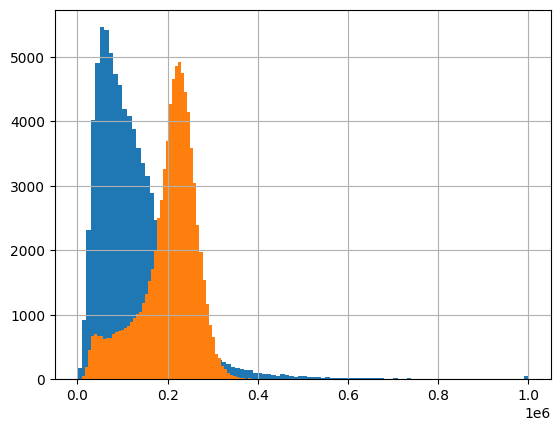

In [90]:
ax = df.avg_d_kbps_mobile.hist(bins=100)
df.avg_d_kbps_fixed.hist(ax=ax, bins=100)
#ax.set_xlim(0, 1_000_000)

                            OLS Regression Results                            
Dep. Variable:      avg_d_kbps_mobile   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     537.7
Date:                Sun, 07 Dec 2025   Prob (F-statistic):          1.44e-118
Time:                        18:13:14   Log-Likelihood:            -1.0559e+06
No. Observations:               82193   AIC:                         2.112e+06
Df Residuals:                   82191   BIC:                         2.112e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           1.13e+05    722.675    156.398

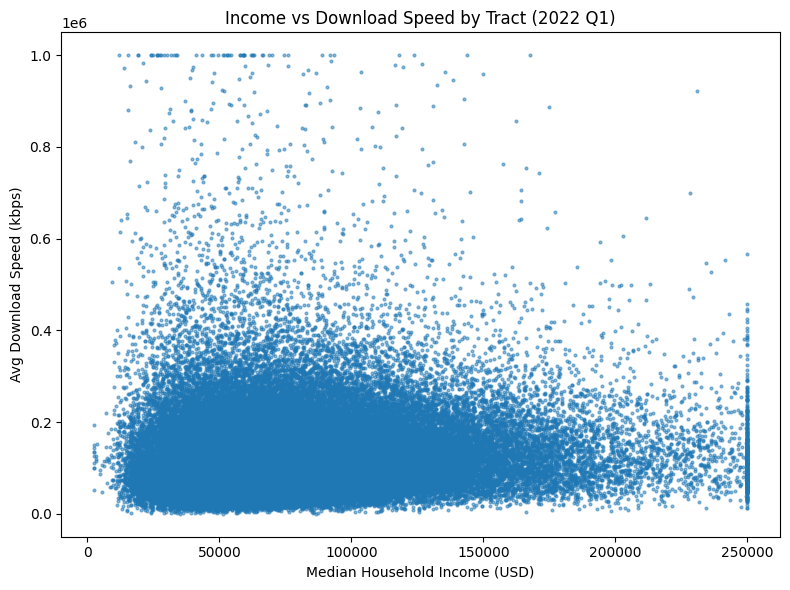

In [92]:
x_var = "median_income"
y_var = "avg_d_kbps_mobile"

t = df.copy()

X = sm.add_constant(t[x_var])  # add intercept

y = t[y_var]

model = sm.OLS(y, X, missing="drop").fit()

print(model.summary())

# Quick scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(t[x_var], t[y_var], s=4, alpha=0.5)
ax.set_xlabel("Median Household Income (USD)")
ax.set_ylabel("Avg Download Speed (kbps)")
ax.set_title("Income vs Download Speed by Tract (2022 Q1)")
plt.tight_layout()
plt.show()

                            OLS Regression Results                            
Dep. Variable:       avg_d_kbps_fixed   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     3350.
Date:                Sun, 07 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:23:50   Log-Likelihood:            -1.0245e+06
No. Observations:               82249   AIC:                         2.049e+06
Df Residuals:                   82247   BIC:                         2.049e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.766e+05    488.322    361.679

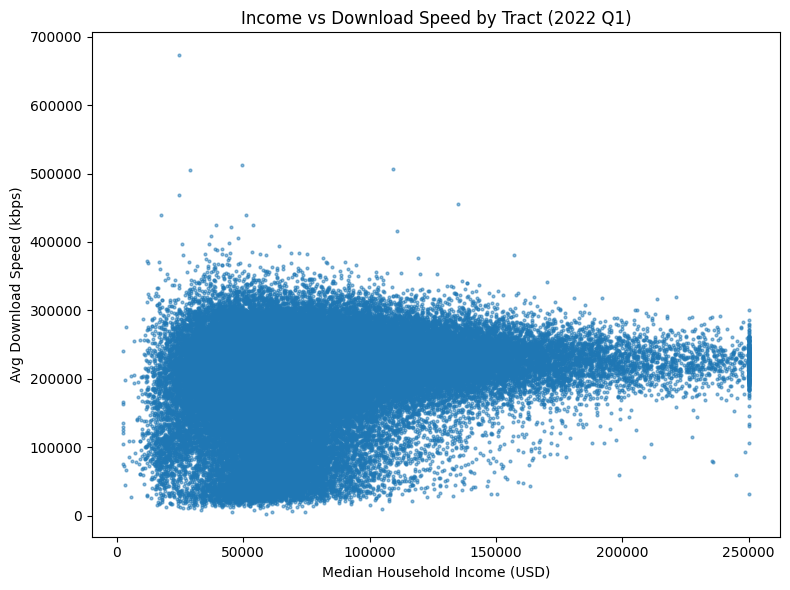

In [100]:
x_var = "median_income"
y_var = "avg_d_kbps_fixed"

t = df.copy()
t = t[t.avg_d_kbps_fixed < 10_000_000]

X = sm.add_constant(t[x_var])  # add intercept

y = t[y_var]

model = sm.OLS(y, X, missing="drop").fit()

print(model.summary())

# Quick scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(t[x_var], t[y_var], s=4, alpha=0.5)
ax.set_xlabel("Median Household Income (USD)")
ax.set_ylabel("Avg Download Speed (kbps)")
ax.set_title("Income vs Download Speed by Tract (2022 Q1)")
plt.tight_layout()
plt.show()